## Getting started

To begin the process of applying neural networks, I first get the data using pytrendsdaily and downloading the search queries information for "pneumonia symptoms" from 2009 up until 2019. (I didn't include the data after the covid outbreak). 

In [1]:
%matplotlib inline
from typing import Sequence
import pandas as pd
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller

import autosklearn.regression
import statsmodels.stats.diagnostic as diag
from scipy.stats import boxcox
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import TimeDistributed
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn


def moving_average_smoothing(series, window = 2):

    rolling = series.rolling(window = window)
    rolling_mean = rolling.mean()
    return rolling_mean


def rss(x,y):
    rss_sum = 0;
    for i in range(len(y)):
        rss_sum += (x[i]-y[i])*(x[i]-y[i]);
    return rss_sum/len(y)


def split_sequence(sequence, lag):
    X, y = list(), list()
    for i in range(lag, len(sequence)):
        # find the end of this pattern
        end_ix = i + lag
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

def MSE(Y, pred):
    return ((Y - pred)**2).mean()

def split_dataset(X, y, Border):
    Xtrain = X[:Border]
    ytrain = y[:Border]

    Xtest = X[Border + 1:]
    ytest = y[Border + 1:]

    return Xtrain, ytrain, Xtest, ytest

data = pd.read_csv('pneumonia2.csv')

sym = data['\"pneumonia symptoms\"']


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Preprocessing the data

By plotting the data, we can observe a lot of noise to it. Before applying the Neural networks, we need to remove as mush noise as we can. <br>
In order to do that, I applied a box-cot transform and then the Adfuller test to see if there is a unit root present in the data. 
It turns out that the Adfuller test rejects that null hypothesis. Because the data is stationary, we can proceed to perform the algorithms.

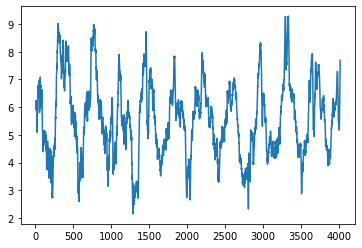

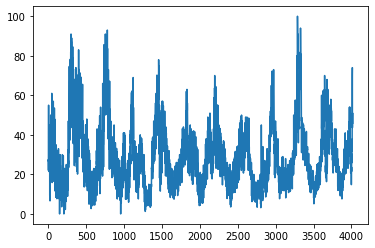

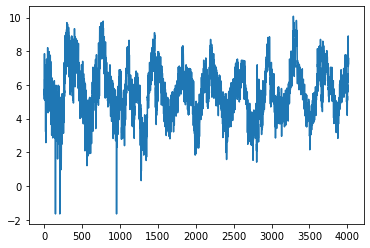

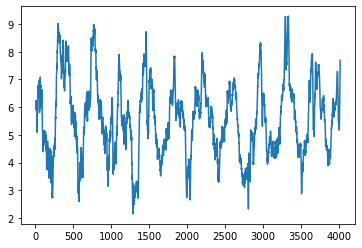

In [2]:
window = 8
# ## apply box-cot transform
transformed = pd.Series(boxcox(np.array(sym) + 0.1)[0]);
# apply smoothing
rolling_mean = moving_average_smoothing(transformed, window = window)
rolling_mean.plot()

    
lag = 3
X, y = split_sequence(transformed, lag)

splitBorder = 2000
Xtrain, ytrain, Xtest, ytest = split_dataset(X, y, splitBorder)

fig = plt.figure()
plt.plot(sym)

fig = plt.figure()
plt.plot(transformed)


fig = plt.figure()
plt.plot(rolling_mean)

In [3]:
# ADF Test
result = adfuller(transformed, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -4.733332
p-value: 0.000073
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject Ho - Time Series is Stationary


The shape of the autocorrelation plot indicates seasonality

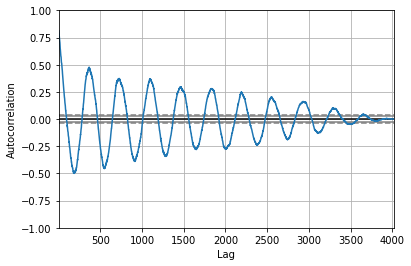

In [4]:
# create an autocorrelation plot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(transformed)
plt.show()

The histogram below, shows that the data have a gaussian form

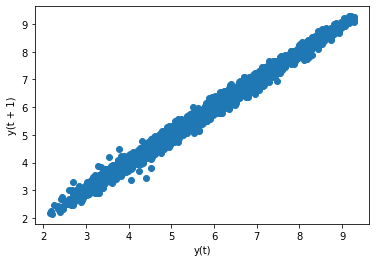

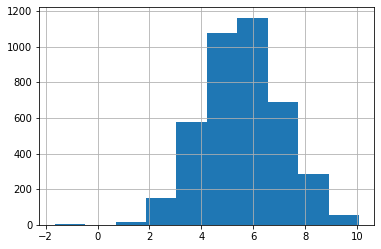

In [5]:
#create lag_plot
from pandas.plotting import lag_plot
lag_plot(rolling_mean)
plt.show()

#create histogram
transformed.hist()
plt.show()

## MLP

<img src="MLP.png">

I applied a simple MLP with two hidden layers, one with 50 nodes and one with 10. 

In [6]:
#MLP with Raw Data
def apply_MLP(Xtrain, ytrain, Xtest, ytest, lag, epochs):
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim = lag))
    model.add(Dense(10))
    model.add(Dense(1))

    model.compile(optimizer = 'adam' , loss = 'mse')
    history = model.fit(Xtrain, ytrain,  validation_data = (Xtest, ytest), epochs=epochs, verbose=0)
    return model, history

## LSTM
<img src="LSTM_Cell.svg.png">
An LSTM cell consists of gates, which help it reuse iformation from previous time steps. At each step, the network decides which data to keep to its memory, and which data to forget.

In [7]:
# define model
def apply_LSTM(Xtrain, ytrain, Xtest, ytest, lag, epochs):
    model = Sequential()
    model.add(LSTM(50, activation= 'relu' , input_shape=(lag, 1)))
    model.add(Dense(1))
    model.compile(optimizer= 'adam' , loss= 'mse')

    history = model.fit(Xtrain, ytrain, validation_data = (Xtest, ytest), epochs=epochs, verbose=0)
    return model, history

LSTM_model = apply_LSTM(Xtrain, ytrain, Xtest, ytest, lag, 20)

2022-06-23 21:00:40.395413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 21:00:40.458022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-11.0/lib64
2022-06-23 21:00:40.458040: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-23 21:00:40.458795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow 

## biLSTM

In bi-directional LSTM, we can make the input flow in both directions to preserve the future and the past information.

In [8]:
# define model
def apply_biLSTM(Xtrain, ytrain, Xtest, ytest, lag, epochs):
    Xtrain_reshaped = Xtrain.reshape((Xtrain.shape[0], Xtrain.shape[1], 1))
    Xtest_reshaped = Xtest.reshape((Xtest.shape[0], Xtest.shape[1], 1))
                                     
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation= 'relu' , input_shape=(lag, 1))))
    model.add(Dense(1))
    model.compile(optimizer= 'adam' , loss= 'mse')

    history = model.fit(Xtrain_reshaped, ytrain, validation_data = (Xtest, ytest), epochs=epochs, verbose=0)
    return model, history



## apply CNN

<img src = "CNN_ex.png">

CNN is mainly used for image recognition, as it can extract patterns off of the data. It can also be used for Time series as the techniques for pattern extraction still apply here

In [9]:
def apply_CNN(Xtrain, ytrain, Xtest, ytest, lag, epochs):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(Xtrain.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(Xtrain, ytrain, epochs=epochs, verbose=0)
    
    return model, history



## Compare the Neural Networks

In this section, I apply the different neural networks for different lag values and compare their performance by plotting the loss with respect to the number of epochs and the lag value.

In [10]:
splitBorder = 3500
epochs = 20
lags = range(2, 20)

MLP_train_history_data = []
LSTM_train_history_data = []
CNN_train_history_data = []
biLSTM_train_history_data = []

for lag in lags:
    X, y = split_sequence(transformed, lag)
    
    Xtrain, ytrain, Xtest, ytest = split_dataset(X, y, splitBorder)
    
    MLPmodel, MLP_history = apply_MLP(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    LSTMmodel, LSTM_history = apply_LSTM(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    CNNmodel, CNN_history = apply_CNN(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    biLSTMmodel, biLSTM_history = apply_biLSTM(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    
    MLP_train_history_data.append(MLP_history.history['loss'])
    LSTM_train_history_data.append(LSTM_history.history['loss'])
    CNN_train_history_data.append(CNN_history.history['loss'])
    biLSTM_train_history_data.append(biLSTM_history.history['loss'])
    

    

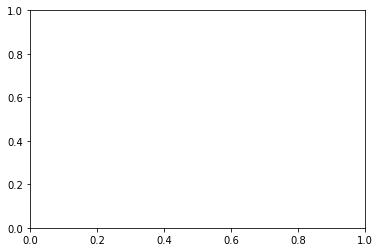

In [11]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

fig, ax = plt.subplots()
def animate(i):
    ax.clear()
    ax.set_title(f"epoch: {i}")
    ax.plot(np.array(MLP_train_history_data)[:,i], label = 'MLP')
    ax.plot(np.array(LSTM_train_history_data)[:,i], label = 'LSTM')
    ax.plot(np.array(CNN_train_history_data)[:,i], label = 'CNN')
    ax.plot(np.array(biLSTM_train_history_data)[:,i], label = 'biLSTM')
    ax.plot()
    ax.legend()
    
ani = FuncAnimation(fig, animate, frames=epochs, interval=1000, repeat=False)

plt.show()


ani.save('c.mp4') 

In [12]:
MLP_best = np.amin(np.array(MLP_train_history_data)[:,epochs-1])
LSTM_best = np.amin(np.array(LSTM_train_history_data)[:,epochs-1])
CNN_best = np.amin(np.array(CNN_train_history_data)[:,epochs-1])
biLSTM_best = np.amin(np.array(biLSTM_train_history_data)[:,epochs-1])

MLP_best_lag = np.where(np.array(MLP_train_history_data)[:,epochs-1] == MLP_best)[0][0] + 2
LSTM_best_lag = np.where(np.array(LSTM_train_history_data)[:,epochs-1] == LSTM_best)[0][0] + 2
CNN_best_lag = np.where(np.array(CNN_train_history_data)[:,epochs-1] == CNN_best)[0][0] + 2
biLSTM_best_lag = np.where(np.array(biLSTM_train_history_data)[:,epochs-1] == biLSTM_best)[0][0] + 2

print(f"best lag of MLP {MLP_best_lag}")
print(f"best lag of LSTM {LSTM_best_lag}")
print(f"best lag of CNN {CNN_best_lag}")
print(f"best lag of biLSTM {biLSTM_best_lag}")


best lag of MLP 7
best lag of LSTM 17
best lag of CNN 18
best lag of biLSTM 15


### Best MSE comparison

| MLP | LSTM | CNN | biLSTM |
| --- | ---  | --- | --- |
| 0.5846 | 0.5864 | 0.5722 | 0.5833|

We can conclude that the CNN network gives the best performace.

### AutoML

In [13]:
# max training time, in seconds
TASK_TIME = 60;
PER_RUN_TIME = 30;

scores = []
for lag in range(1,20):
    automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=TASK_TIME,
        per_run_time_limit=PER_RUN_TIME,
        memory_limit=15000
  )
    automl.fit(Xtrain, ytrain)
    print("For lag = ", lag)
    predictions = automl.predict(Xtest)
    scores.append(sklearn.metrics.mean_squared_error(predictions, ytest))
    print(f"MSE: {sklearn.metrics.mean_squared_error(predictions, ytest)}")


[WARNING] [2022-06-23 21:08:56,844:Client-AutoML(1):8c0bc3b1-f31f-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  1
MSE: 0.3692861613188754
[WARNING] [2022-06-23 21:09:51,570:Client-AutoML(1):acc8bf16-f31f-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  2
MSE: 0.3692861613188754
[WARNING] [2022-06-23 21:11:02,784:Client-AutoML(1):cceecaed-f31f-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  3
MSE: 0.3692861613188754
[WARNING] [2022-06-23 21:12:06,396:Client-AutoML(1):f7796a5f-f31f-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  4
MSE: 0.3692861613188754
[WARNING] [2022-06-23 21:13:00,884:Client-AutoML(1):1dcaa104-f320-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to 

In [14]:
print(f"minimum mse of AutoML: {np.amin(scores)}")

minimum mse of AutoML: 0.3692861613188754


We can observe that the autoML framework performs better than the Neural network architectures that I implemented. This can be attributed to the sophisticated algorithms used for tuning the hyperparameters.

### And now some visualization

15/15 [==============================] - 0s 4ms/step


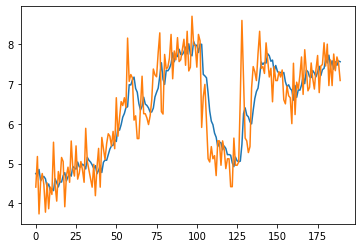

In [15]:
X, y = split_sequence(transformed, 19)
Xtrain, ytrain, Xtest, ytest = split_dataset(X, y, splitBorder)

predictions = LSTMmodel.predict(Xtest)

figure = plt.figure()

plt.plot(predictions[10:200])
plt.plot(ytest[10:200])
plt.show()

# perform analysis on the rolling mean

At first, I apply the moving average smoothing function with a window of 10 and then take the difference of the moving average and the transformed data. If their difference is shite noise, then that means that the smoothing is succesful and no information is lost.

10     -0.179812
11      0.207349
12     -0.560844
13      0.538224
14     -0.321150
          ...   
4012    2.060398
4013    0.144171
4014    0.345493
4015    0.325423
4016   -0.191162
Length: 4007, dtype: float64


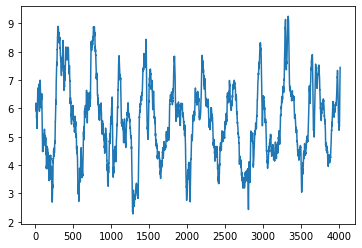

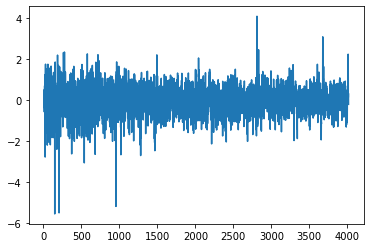

In [16]:
# apply smoothing
window = 10
rolling_mean = moving_average_smoothing(transformed, window = window)[window:]
fig = plt.figure()
rolling_mean.plot()

difference = transformed[window:] - rolling_mean

fig = plt.figure()
plt.plot(difference)

In [17]:
diag.acorr_ljungbox(difference, lags=[20], return_df=True)

,lb_stat,lb_pvalue
20,283.665378,1.727123e-48


The p-value of the ljungbox test proves that the difference is indeed white noise, so we can continue with the implementation

In [18]:
splitBorder = 3500
epochs = 30
lags = range(5, 20)

MLP_train_history_data = []
LSTM_train_history_data = []
CNN_train_history_data = []
biLSTM_train_history_data = []

for lag in lags:
    X, y = split_sequence(rolling_mean, lag)
    
    Xtrain, ytrain, Xtest, ytest = split_dataset(X, y, splitBorder)
    
    MLPmodel, MLP_history = apply_MLP(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    LSTMmodel, LSTM_history = apply_LSTM(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    CNNmodel, CNN_history = apply_CNN(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    biLSTMmodel, biLSTM_history = apply_biLSTM(Xtrain, ytrain, Xtest, ytest, lag, epochs)
    
    MLP_train_history_data.append(MLP_history.history['loss'])
    LSTM_train_history_data.append(LSTM_history.history['loss'])
    CNN_train_history_data.append(CNN_history.history['loss'])
    biLSTM_train_history_data.append(biLSTM_history.history['loss'])
    

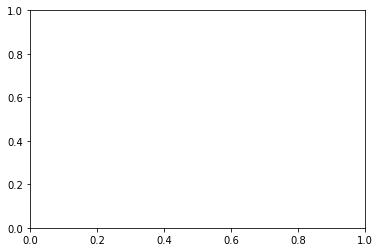

In [19]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

fig, ax = plt.subplots()
def animate(i):
    ax.clear()
    ax.set_title(f"epoch: {i}")
    ax.plot(np.array(MLP_train_history_data)[:,i], label = 'MLP')
    ax.plot(np.array(LSTM_train_history_data)[:,i], label = 'LSTM')
    ax.plot(np.array(CNN_train_history_data)[:,i], label = 'CNN')
    ax.plot(np.array(biLSTM_train_history_data)[:,i], label = 'biLSTM')
    ax.plot()
    ax.legend()
    
ani = FuncAnimation(fig, animate, frames=epochs, interval=1000, repeat=False)

plt.show()
200

ani.save('rolling_mean.mp4') 

15/15 [==============================] - 0s 3ms/step


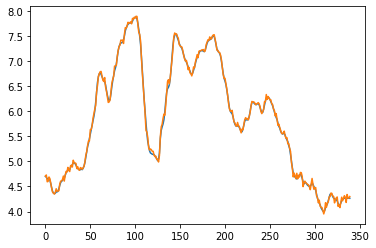

In [20]:
X, y = split_sequence(rolling_mean, 19)
Xtrain, ytrain, Xtest, ytest = split_dataset(X, y, splitBorder)

predictions = LSTMmodel.predict(Xtest)

figure = plt.figure()

plt.plot(predictions[10:350])
plt.plot(ytest[10:350])
plt.show()

In [21]:
MLP_best = np.amin(np.array(MLP_train_history_data)[:,epochs-1])
LSTM_best = np.amin(np.array(LSTM_train_history_data)[:,epochs-1])
CNN_best = np.amin(np.array(CNN_train_history_data)[:,epochs-1])
biLSTM_best = np.amin(np.array(biLSTM_train_history_data)[:,epochs-1])

MLP_best_lag = np.where(np.array(MLP_train_history_data)[:,epochs-1] == MLP_best)[0][0] + 2
LSTM_best_lag = np.where(np.array(LSTM_train_history_data)[:,epochs-1] == LSTM_best)[0][0] + 2
CNN_best_lag = np.where(np.array(CNN_train_history_data)[:,epochs-1] == CNN_best)[0][0] + 2
biLSTM_best_lag = np.where(np.array(biLSTM_train_history_data)[:,epochs-1] == biLSTM_best)[0][0] + 2

print(f"best lag of MLP {MLP_best_lag}")
print(f"best lag of LSTM {LSTM_best_lag}")
print(f"best lag of CNN {CNN_best_lag}")
print(f"best lag of biLSTM {biLSTM_best_lag}")

print(f"MLP best score {MLP_best}")
print(f"LSTM best score {LSTM_best}")
print(f"CNN best score {CNN_best}")
print(f"biLSTM best score {biLSTM_best}")

best lag of MLP 10
best lag of LSTM 13
best lag of CNN 7
best lag of biLSTM 7
MLP best score 0.001400428474880755
LSTM best score 0.0036676761228591204
CNN best score 7.089422069839202e-06
biLSTM best score 0.001520009827800095


We can again observe that the convolutional neural network has the best performance.

###  AutoML

In [22]:
# max training time, in seconds
TASK_TIME = 60;
PER_RUN_TIME = 30;

scores = []
for lag in range(1,20):
    automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=TASK_TIME,
        per_run_time_limit=PER_RUN_TIME,
        memory_limit=15000
  )
    automl.fit(Xtrain, ytrain)
    print("For lag = ", lag)
    predictions = automl.predict(Xtest)
    scores.append(sklearn.metrics.mean_squared_error(predictions, ytest))
    print(f"MSE: {sklearn.metrics.mean_squared_error(predictions, ytest)}")

[WARNING] [2022-06-23 21:42:08,245:Client-AutoML(1):2ea4866d-f324-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  1
MSE: 6.3629467784643635e-06
[WARNING] [2022-06-23 21:43:05,896:Client-AutoML(1):5019f110-f324-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  2
MSE: 6.3629467784643635e-06
[WARNING] [2022-06-23 21:44:12,167:Client-AutoML(1):7274ffdd-f324-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  3
MSE: 6.3629467784643635e-06
[WARNING] [2022-06-23 21:45:07,709:Client-AutoML(1):99aa831a-f324-11ec-a181-c757246179f2] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
For lag =  4
MSE: 6.3629467784643635e-06
[WARNING] [2022-06-23 21:46:03,237:Client-AutoML(1):bb1eed6a-f324-11ec-a181-c757246179f2] Capping the per_run_time_l

In [23]:
print(f"minimum mse of AutoML: {np.amin(scores)}")

minimum mse of AutoML: 6.3629467784643635e-06
